In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time
import tensorflow as tf
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


TensorFlow version: 2.9.2
Num GPUs Available:  1
CPU times: user 420 ms, sys: 33.7 ms, total: 454 ms
Wall time: 453 ms


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tomato/PlantVillage/PlantVillage",
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 4002 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(dataset)

126

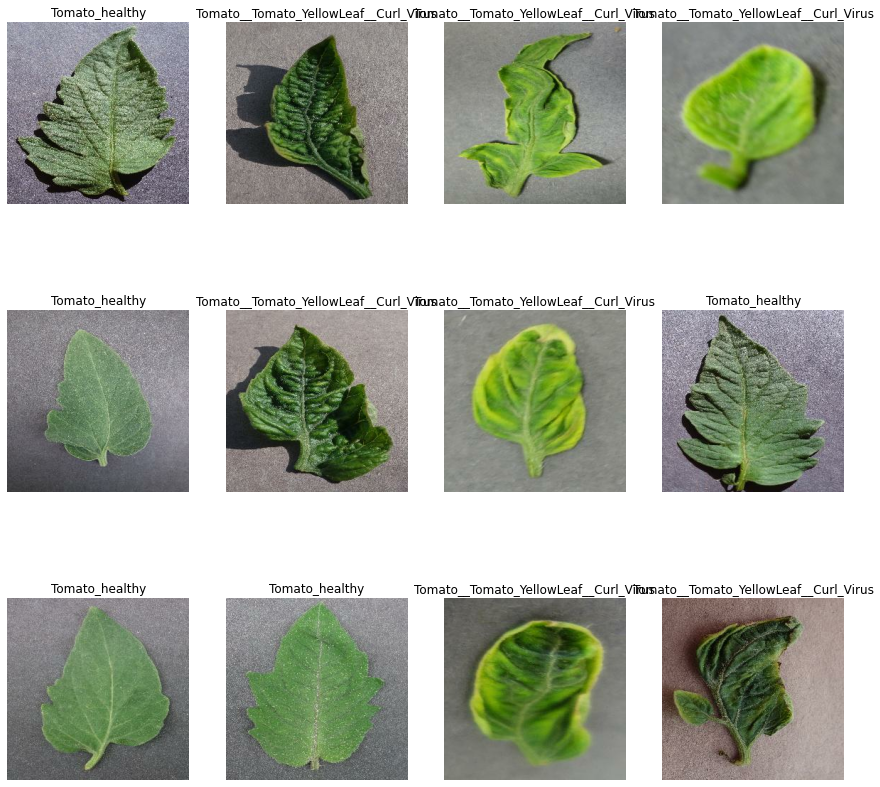

In [10]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

In [ ]:
train_ds = dataset.take(400)
len(train_ds)

In [ ]:
test_ds = dataset.skip(400)
len(test_ds)

In [ ]:
val_size = 0.1
len(dataset)*val_size

In [ ]:
val_ds = test_ds.take(50)
len(val_ds)

In [ ]:
test_ds = test_ds.skip(50)
len(test_ds)

Train Test Split

In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

100

In [14]:
len(val_ds)

12

In [15]:
len(test_ds)

14

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Model Building using CNN

In [19]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
    
])
model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
100/100 [==============================] - 527s 168ms/step - loss: 0.4792 - accuracy: 0.7716 - val_loss: 0.0676 - val_accuracy: 0.9740
Epoch 2/50
100/100 [==============================] - 9s 92ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0328 - val_accuracy: 0.9896
Epoch 3/50
100/100 [==============================] - 9s 92ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0202 - val_accuracy: 0.9896
Epoch 4/50
100/100 [==============================] - 9s 92ms/step - loss: 0.0437 - accuracy: 0.9878 - val_loss: 0.0354 - val_accuracy: 0.9844
Epoch 5/50
100/100 [==============================] - 9s 92ms/step - loss: 0.0472 - accuracy: 0.9841 - val_loss: 0.0036 - val_accuracy: 0.9974
Epoch 6/50
100/100 [==============================] - 9s 92ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.0053 - val_accuracy: 0.9974
Epoch 7/50
100/100 [==============================] - 9s 94ms/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.0116 - val_accuracy: 0.9

In [23]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 11s 51ms/step - loss: 0.0084 - accuracy: 0.9952


In [24]:
scores

[0.008443883620202541, 0.9952152967453003]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

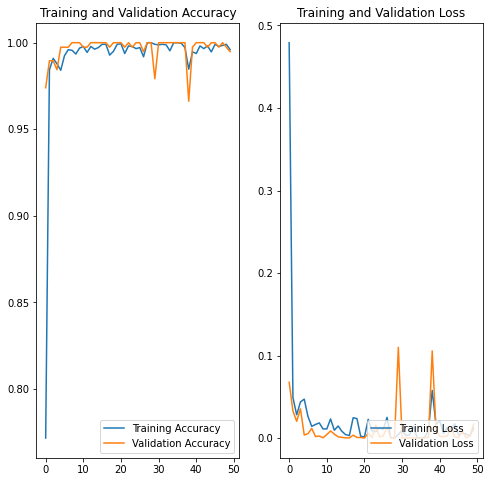

In [26]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Tomato_healthy
1/1 [==============================] - 0s 146ms/step
Predicted Label: Tomato_healthy


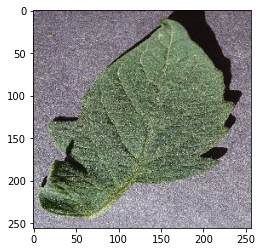

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy().astype('uint8')
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


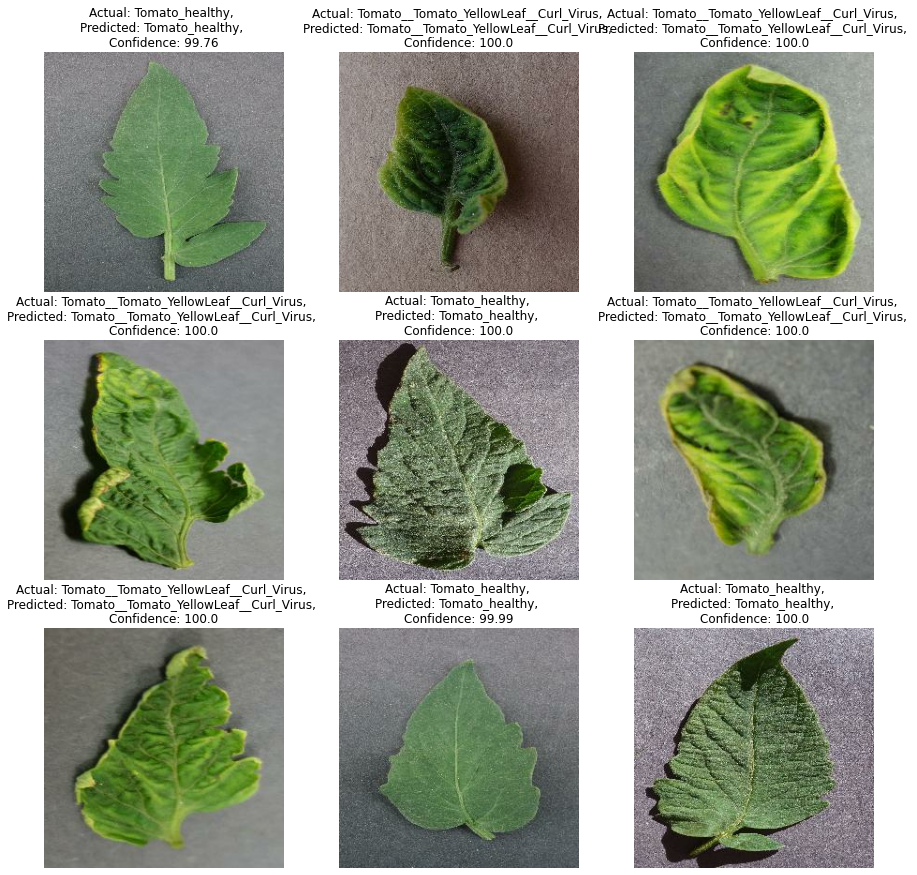

In [30]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):    
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}")
        
        plt.axis("off")

In [32]:
model_version = 1
model.save(f"./drive/MyDrive/Tomato/{model_version}")